# Problem Statement: Sentiment Analysis Using TF-IDF Vectors


Design and implement a machine learning model to perform sentiment analysis on a given
dataset containing textual data and corresponding sentiment labels. The analysis should use
TF-IDF (Term Frequency-Inverse Document Frequency) vectors to transform the text into
numerical features and classify the sentiments effectively.

dataset: [https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset/data?select=training.1600000.processed.noemoticon.csv]

```bash
#!/bin/bash
curl -L -o ~/Downloads/sentiment-analysis-dataset.zip\
  https://www.kaggle.com/api/v1/datasets/download/abhi8923shriv/sentiment-analysis-dataset
  
```

Content:
The dataset is stored in a CSV file and includes six fields:
1. Polarity (Column 0):
○ Sentiment label for the tweet:
  ■ 0: Negative sentiment
  ■ 2: Neutral sentiment
  ■ 4: Positive sentiment
2. Tweet ID (Column 1):
○ A unique identifier for each tweet.
3. Date (Column 2):
  ○ The timestamp of when the tweet was posted, in the format Day Month Date
  HH:MM:SS UTC Year (e.g., Sat May 16 23:58:44 UTC 2009).
4. Query (Column 3):
  ○ The search query used to retrieve the tweet. If no query was used, the value is
  NO_QUERY.
5. User (Column 4):
  ○ The username of the account that posted the tweet (e.g., robotickilldozr).
6. Text (Column 5):
  ○ The content of the tweet, consisting of raw text after emoticons have been removed
  (e.g., Lyx is cool)


**Chosen Classicla ML model:** 
    Baseline: Naive Bayse 
    *Inspiration* [https://www.researchgate.net/publication/379406018_Sentiment_analysis_based_on_machine_learning_models#:~:text=This%20paper%20undertakes%20an%20investigation,perform%20poorly%20on%20IMDB%20dataset.]



In [29]:
import pandas as pd
import spacy
from sklearn.model_selection import train_test_split
import numpy as np
import re
# Set seed
np.random.seed(42)

In [ ]:
# Load the Sentiment Analysis dataset
# Load train and test CSV files
test_df = pd.read_csv('sentiment-analysis-dataset/testdata.manual.2009.06.14.csv', encoding='latin1')
train_df = pd.read_csv('sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv', encoding='latin1')
train_df.head(2)

,polarity of tweet,id of the tweet,date of the tweet,query,user,text of the tweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...


In [2]:
print(f"Test set columns: {test_df.columns}")
test_df.head(3) 


Test set columns: Index(['4', '3', 'Mon May 11 03:17:40 UTC 2009', 'kindle2', 'tpryan',
       '@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.'],
      dtype='object')


,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
0,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
1,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
2,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...


**NOTE**
The test_df has a different structure compared to train_df.
Perhaps, we are only supposed to use the train_df. 

This notebook proceeds with only using the train_df and splitting it into train, val, and test sets.

# Preprocess Tweets

In [3]:
# Load the SpaCy English model
# Since we are not using NER, we can disable it to speedup
nlp = spacy.load("en_core_web_sm", disable='ner')

In [5]:
# from: 'NLP Notebooks/Module 2/Module 2 - Game_Reviews_Classification (For Recording).ipynb'
def preprocess_text(texts):
    """Function for text lemmatization and stop word removal"""
    # lemmatize the tokens and store them in a list
    processed_texts = []
    for doc in nlp.pipe(texts, n_process=-1):
        # Only keep lemmatized tokens that are alphabetic (composed of letters only, e.g. "word", "hello").
        # This excludes tokens with numbers or special characters (e.g. "123", "hello!", "word2", "@user").
        # Note: "is_alpha" selects tokens with only alphabetic characters.
        lemmatized_tokens = [
            token.lemma_.lower()
            for token in doc
            if token.is_alpha and token.lemma_ not in nlp.Defaults.stop_words
        ]
        
        # Join the lemmatized tokens into a string
        processed_text = " ".join(lemmatized_tokens)
        
        processed_texts.append(processed_text)
        
    return processed_texts

In [6]:
print(f'Columns in the dataset: {train_df.columns}')
# Fix extract space in col names
train_df.columns = [col.strip() for col in train_df.columns]
print(f"New column names: {train_df.columns}")

Columns in the dataset: Index(['polarity of tweet ', 'id of the tweet', 'date of the tweet', 'query',
       'user', 'text of the tweet '],
      dtype='object')
New column names: Index(['polarity of tweet', 'id of the tweet', 'date of the tweet', 'query',
       'user', 'text of the tweet'],
      dtype='object')


In [7]:
# APPLY PREPROCESSING: 
train_df['text of the tweet'] = preprocess_text(train_df['text of the tweet'])

In [8]:
train_df['text of the tweet'].head(2)
# note:
    # it completely removed user names from the texts:
        # examples: @Kenichan, @nationwideclass, @Kwesidei, etc.. 

0    upset update facebook texte cry result school ...
1              i dive time ball manage save rest bound
Name: text of the tweet, dtype: object

# **Inspect Label Distribution**

In [11]:
print('Samples in training set: ', train_df.shape[0])
print("Tweet Polarity Distribution in Training Set")
value_counts = train_df['polarity of tweet'].value_counts()
percentage = value_counts / value_counts.sum() * 100
result = pd.DataFrame({'count': value_counts, 'percentage': percentage})
print(result)


Samples in training set:  1048572
Tweet Polarity Distribution in Training Set
                    count  percentage
polarity of tweet                    
0                  799996   76.293855
4                  248576   23.706145


*CLASS IMBALANCE ANALYSIS*

The dataset shows a significant class imbalance:
- **Class 0 (Negative)**: ~76.29%
- **Class 4 (Positive)**: ~23.71%

**NOTE THAT THE DATASET DID NOT HAVE THE NEUTRAL LABEL**


# **Split into Train,Val,Test**

## Handling Class Imbalance

## Undersampling for Balance 

In [ ]:
# from sklearn.model_selection import train_test_split
# import numpy as np

# # Copy original data
# df = train_df.copy()

# # Define features and target
# X = df['text of the tweet']
# y = df['polarity of tweet']

# # BALANCED SPLIT: Split each class separately to ensure 50-50 distribution
# # Separate data by class
# class_0_mask = y == 0
# class_4_mask = y == 4

# X_class_0 = X[class_0_mask]
# y_class_0 = y[class_0_mask]
# X_class_4 = X[class_4_mask]
# y_class_4 = y[class_4_mask]

# print(f"Class 0 samples: {len(X_class_0)}")
# print(f"Class 4 samples: {len(X_class_4)}")

# # Determine the minimum class size to use for balanced splits
# min_class_size = min(len(X_class_0), len(X_class_4))
# print(f"\nUsing {min_class_size} samples per class for balanced splits\n")

# # Sample equal number from each class (undersample majority class)
# np.random.seed(42)
# class_0_indices = np.random.choice(len(X_class_0), min_class_size, replace=False)
# class_4_indices = np.random.choice(len(X_class_4), min_class_size, replace=False)

# X_class_0_balanced = X_class_0.iloc[class_0_indices]
# y_class_0_balanced = y_class_0.iloc[class_0_indices]
# X_class_4_balanced = X_class_4.iloc[class_4_indices]
# y_class_4_balanced = y_class_4.iloc[class_4_indices]

# # Combine balanced classes
# X_balanced = pd.concat([X_class_0_balanced, X_class_4_balanced], ignore_index=True)
# y_balanced = pd.concat([y_class_0_balanced, y_class_4_balanced], ignore_index=True)

# # Shuffle the combined data
# shuffle_indices = np.random.permutation(len(X_balanced))
# X_balanced = X_balanced.iloc[shuffle_indices].reset_index(drop=True)
# y_balanced = y_balanced.iloc[shuffle_indices].reset_index(drop=True)

# # Now split the balanced data: First split to (train+val) and test (80% train+val, 20% test)
# X_trainval, X_test, y_trainval, y_test = train_test_split(
#     X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
# )

# # Now split train+val into train and val (80% train, 20% val of the remaining)
# X_train, X_val, y_train, y_val = train_test_split(
#     X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval
# )

# print(f"Train set shape: {X_train.shape}")
# print(f"Val set shape:   {X_val.shape}")
# print(f"Test set shape:  {X_test.shape}\n")

# def print_class_balance(y, set_name=""):
#     value_counts = y.value_counts()
#     percentage = value_counts / value_counts.sum() * 100
#     balance_df = pd.DataFrame({'count': value_counts, 'percentage': percentage.round(2)})
#     print(f"{set_name} class balance:\n{balance_df}\n")

# print_class_balance(y_train, "Train")
# print_class_balance(y_val, "Val")
# print_class_balance(y_test, "Test")


**UNDERSAMPLING**

Reduces the dataset from ~1,048,572 to ~497,152 samples.

**Trade-offs:**
- ✅ Perfect 50-50 class balance
- ❌ Loses ~551,420 samples (mostly from majority class)
- ❌ May lose valuable information from discarded samples

**Alternative: OVERSAMPLING approach (see cell below)**
- ✅ Keeps ALL original samples (1,048,572 → ~1,599,992 samples)
- ✅ Perfect 50-50 class balance
- ⚠️ Creates duplicate samples in minority class (may cause slight overfitting)


## Oversampling for Balance (Picked Approach)


In [12]:
# OVERSAMPLING APPROACH (preserves all data)

# Copy original data
df = train_df.copy()

# Define features and target
X = df['text of the tweet']
y = df['polarity of tweet']

# BALANCED SPLIT: Using OVERSAMPLING to preserve more data
# This approach keeps ALL majority class samples and oversamples the minority class
# Separate data by class
class_0_mask = y == 0
class_4_mask = y == 4

X_class_0 = X[class_0_mask]
y_class_0 = y[class_0_mask]
X_class_4 = X[class_4_mask]
y_class_4 = y[class_4_mask]

print(f"Original - Class 0 samples: {len(X_class_0)}")
print(f"Original - Class 4 samples: {len(X_class_4)}")

# Use ALL samples from class 0 (majority class)
# Oversample class 4 (minority class) to match class 0 size
max_class_size = len(X_class_0)  # Use majority class size as target
print(f"\nTarget size per class: {max_class_size} samples")
print(f"Class 4 needs {max_class_size - len(X_class_4)} additional samples (oversampling)\n")


# For class 0: Use all samples (no sampling needed - preserves all data!)
X_class_0_balanced = X_class_0.copy()
y_class_0_balanced = y_class_0.copy()

# For class 4: Oversample to match class 0 size
# Calculate how many additional samples we need
additional_samples_needed = max_class_size - len(X_class_4)

# Randomly sample WITH replacement from class 4 to create additional samples
oversample_indices = np.random.choice(len(X_class_4), additional_samples_needed, replace=True)

# Get the oversampled data
X_class_4_oversampled = X_class_4.iloc[oversample_indices]
y_class_4_oversampled = y_class_4.iloc[oversample_indices]

# Combine original class 4 samples with oversampled ones
X_class_4_balanced = pd.concat([X_class_4, X_class_4_oversampled], ignore_index=True)
y_class_4_balanced = pd.concat([y_class_4, y_class_4_oversampled], ignore_index=True)

print(f"After oversampling:")
print(f"  Class 0: {len(X_class_0_balanced)} samples (all original samples preserved)")
print(f"  Class 4: {len(X_class_4_balanced)} samples ({len(X_class_4)} original + {additional_samples_needed} oversampled)")
print(f"  Total: {len(X_class_0_balanced) + len(X_class_4_balanced)} samples\n")

# Combine balanced classes
X_balanced = pd.concat([X_class_0_balanced, X_class_4_balanced], ignore_index=True)
y_balanced = pd.concat([y_class_0_balanced, y_class_4_balanced], ignore_index=True)

# Shuffle the combined data
shuffle_indices = np.random.permutation(len(X_balanced))
X_balanced = X_balanced.iloc[shuffle_indices].reset_index(drop=True)
y_balanced = y_balanced.iloc[shuffle_indices].reset_index(drop=True)

# Now split the balanced data: First split to (train+val) and test (90% train+val, 20% test)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.1, random_state=42, stratify=y_balanced
)

# Now split train+val into train and val (80% train, 20% val of the remaining)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval
)

print(f"Train set shape: {X_train.shape}")
print(f"Val set shape:   {X_val.shape}")
print(f"Test set shape:  {X_test.shape}\n")

def print_class_balance(y, set_name=""):
    value_counts = y.value_counts()
    percentage = value_counts / value_counts.sum() * 100
    balance_df = pd.DataFrame({'count': value_counts, 'percentage': percentage.round(2)})
    print(f"{set_name} class balance:\n{balance_df}\n")

print_class_balance(y_train, "Train")
print_class_balance(y_val, "Val")
print_class_balance(y_test, "Test")


Original - Class 0 samples: 799996
Original - Class 4 samples: 248576

Target size per class: 799996 samples
Class 4 needs 551420 additional samples (oversampling)

After oversampling:
  Class 0: 799996 samples (all original samples preserved)
  Class 4: 799996 samples (248576 original + 551420 oversampled)
  Total: 1599992 samples

Train set shape: (1151993,)
Val set shape:   (287999,)
Test set shape:  (160000,)

Train class balance:
                    count  percentage
polarity of tweet                    
4                  575997        50.0
0                  575996        50.0

Val class balance:
                    count  percentage
polarity of tweet                    
0                  144000        50.0
4                  143999        50.0

Test class balance:
                   count  percentage
polarity of tweet                   
0                  80000        50.0
4                  80000        50.0



## Create out Vocabulary with the Training Set 

In [30]:
vocabulary = set()

# BUILD VOCABULARY BASED ON THE TRAINING SET

for row in X_train:
    word_based_tokens = row.split(" ")
    for token in word_based_tokens:
        # avoid tokens like: 'aaaaaaaaaaaaaaaghh' 
        if len(token) > 20:
            continue

        # remove tokens which have the same letter repeated more than 5 times in a row
        if re.search(r'(.)\1{5,}', token):
            continue

        vocabulary.add(token)

# Convert the set to a sorted list if you want the vocabulary to be ordered
vocabulary = sorted(list(vocabulary))

# Print the vocabulary
print(f"Vocabulary Size: {len(vocabulary)}")

Vocabulary Size: 150457


# Vectorization

In [32]:
# import necessary library
from sklearn.feature_extraction.text import TfidfVectorizer

In [33]:
# initialize tfidf vectorizer with custom vocabulary
# min_df is the minimum document frequency; terms that appear in fewer documents than this threshold will be ignored
tfidf_vectorizer = TfidfVectorizer(min_df=0.001, vocabulary=vocabulary)

# Naive Bayes Model 

In [34]:
from sklearn.naive_bayes import BernoulliNB
naive_bayes_classifier = BernoulliNB()

In [35]:
#create the naive bayes model for the train data using tfidf
tfidf_vectorizer_train = tfidf_vectorizer.fit_transform(X_train)

# The shape of the TF-IDF vector is (num_documents, vocab_size)
# - num_documents: the number of reviews/documents in the training set (each row)
# - vocab_size: the number of unique words (features/terms) in the vocabulary after preprocessing (each column)
print("TF-IDF vector shape:", tfidf_vectorizer_train.shape)
print("TF-IDF vector type:", type(tfidf_vectorizer_train))
print("\nFirst 5 rows of TF-IDF vector:")
print(tfidf_vectorizer_train[:5])

naive_bayes_classifier.fit(tfidf_vectorizer_train, y_train)
naive_bayes_classifier.score(tfidf_vectorizer_train, y_train)

TF-IDF vector shape: (1151993, 150457)
TF-IDF vector type: <class 'scipy.sparse._csr.csr_matrix'>

First 5 rows of TF-IDF vector:
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 30 stored elements and shape (5, 150457)>
  Coords	Values
  (0, 15976)	0.4559550013654471
  (0, 46196)	0.3221890297790453
  (0, 73871)	0.21570162832325304
  (0, 83432)	0.2974302117413544
  (0, 96026)	0.2891792714743577
  (0, 107345)	0.3747040270059657
  (0, 107954)	0.34955750750983205
  (0, 122900)	0.27979967451249027
  (0, 131449)	0.17490828064288838
  (0, 133842)	0.31338214378917956
  (1, 39815)	0.305804420522364
  (1, 96670)	0.6029704526516706
  (1, 102640)	0.2958124053596225
  (1, 139273)	0.3960506766751391
  (1, 145495)	0.4758058534530421
  (1, 148289)	0.2686223404305037
  (2, 8695)	0.33675777666138473
  (2, 22804)	0.44995280303713947
  (2, 57482)	0.35046456138664883
  (2, 65811)	0.6478929556457206
  (2, 97029)	0.37622597482605913
  (3, 26030)	0.22882141247422863
  (3, 33247)	0.48201263764709

0.7969527592615581

In [37]:
tfidf_vectorizer_val = tfidf_vectorizer.transform(X_val)
naive_bayes_classifier.score(tfidf_vectorizer_val, y_val)

0.7776346445647381

In [38]:
# Evaluate on TEST set (final evaluation)
tfidf_vectorizer_test = tfidf_vectorizer.transform(X_test)
test_accuracy = naive_bayes_classifier.score(tfidf_vectorizer_test, y_test)
print(f"Test Set Accuracy: {test_accuracy:.4f}")


Test Set Accuracy: 0.7794


# Model Evaluation Summary


In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions for all sets
y_train_pred = naive_bayes_classifier.predict(tfidf_vectorizer_train)
y_val_pred = naive_bayes_classifier.predict(tfidf_vectorizer_val)
y_test_pred = naive_bayes_classifier.predict(tfidf_vectorizer_test)

# Print accuracy for all sets
print("=" * 60)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 60)
print(f"Train Accuracy:  {naive_bayes_classifier.score(tfidf_vectorizer_train, y_train):.4f}")
print(f"Val Accuracy:    {naive_bayes_classifier.score(tfidf_vectorizer_val, y_val):.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}")
print("=" * 60)

# Detailed classification report for test set
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Negative (0)', 'Positive (4)']))


MODEL PERFORMANCE SUMMARY
Train Accuracy:  0.7970
Val Accuracy:    0.7776
Test Accuracy:  0.7794

Test Set Classification Report:
              precision    recall  f1-score   support

Negative (0)       0.79      0.76      0.78     80000
Positive (4)       0.77      0.80      0.78     80000

    accuracy                           0.78    160000
   macro avg       0.78      0.78      0.78    160000
weighted avg       0.78      0.78      0.78    160000



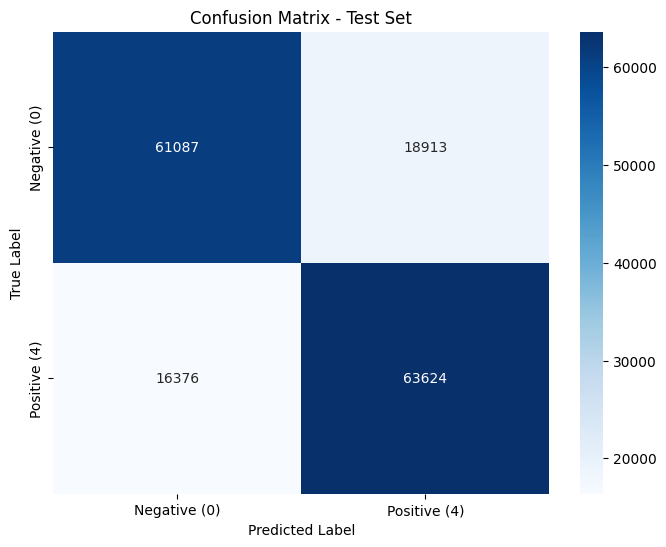


Confusion Matrix:
[[61087 18913]
 [16376 63624]]

True Negatives (TN): 61087
False Positives (FP): 18913
False Negatives (FN): 16376
True Positives (TP): 63624


In [41]:
# Confusion Matrix for Test Set
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative (0)', 'Positive (4)'],
            yticklabels=['Negative (0)', 'Positive (4)'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(f"\nConfusion Matrix:\n{cm}")
print(f"\nTrue Negatives (TN): {cm[0][0]}")
print(f"False Positives (FP): {cm[0][1]}")
print(f"False Negatives (FN): {cm[1][0]}")
print(f"True Positives (TP): {cm[1][1]}")
